# Initial VAE Testing Notebook

The base code for this notebook is adapted from: https://keras.io/examples/variational_autoencoder/

The example provided at, https://keras.io/examples, are a very good starting place for creating more complicated neural network models and only require very basic modification from the original Keras API to work with the new TensorFlow 2.0 Keras API.


In [ ]:
#!pip install tensorflow numpy matplotlib pydot graphviz
#!pip install --upgrade h5py

import tensorflow

print(f"TensorFlow Version: {tensorflow.version.VERSION}")

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [4]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [6]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2


11493376/11490434 [==============================] - 0s 0us/step


In [7]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', name='x')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [8]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu', name='out_x')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid', name='output')(x)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
x (Dense)                       (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        x[0][0]                          
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        x[0][0]                          
____________________________________________________________________________________________

In [9]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
out_x (Dense)                (None, 512)               1536      
_________________________________________________________________
output (Dense)               (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          403728      encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_clip_by_value/Minim [(None, 784)]        0           decoder[1][0]                    
____________________________________________________________________________________________

60000/60000 [==============================] - 5s 81us/sample - loss: 157.2142 - val_loss: 157.2073
Epoch 9/50
60000/60000 [==============================] - 5s 87us/sample - loss: 156.2381 - val_loss: 156.3869
Epoch 10/50
60000/60000 [==============================] - 5s 88us/sample - loss: 155.3892 - val_loss: 155.7607
Epoch 11/50
60000/60000 [==============================] - 5s 88us/sample - loss: 154.6308 - val_loss: 155.1470
Epoch 12/50
60000/60000 [==============================] - 5s 89us/sample - loss: 153.9720 - val_loss: 154.5665
Epoch 13/50
60000/60000 [==============================] - 5s 89us/sample - loss: 153.4009 - val_loss: 154.1348
Epoch 14/50
60000/60000 [==============================] - 5s 86us/sample - loss: 152.8415 - val_loss: 153.7197
Epoch 15/50
60000/60000 [==============================] - 5s 87us/sample - loss: 152.4168 - val_loss: 153.4565
Epoch 16/50
60000/60000 [==============================] - 5s 88us/sample - loss: 151.9568 - val_loss: 153.1049
Epoch

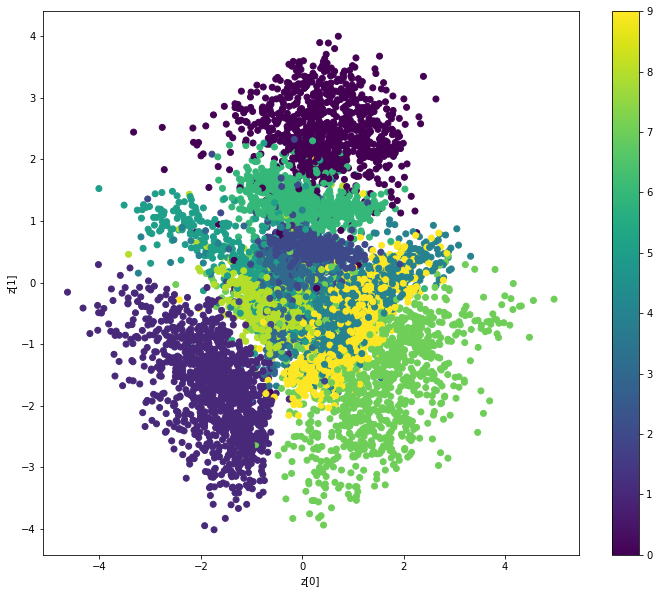

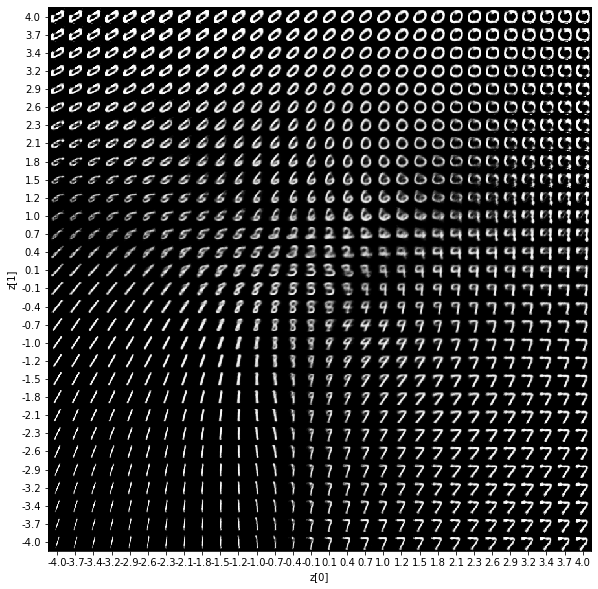

In [10]:
models = (encoder, decoder)
data = (x_test, y_test)

MSE = False
WEIGHTS = False

epochs = 50

# VAE loss = mse_loss or xent_loss + kl_loss
if MSE:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

if WEIGHTS:
    vae.load_model('vae_mlp_mnist.h5')
else:
    # train the autoencoder
    vae.fit(
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None)
    )   

plot_results(
    models,
    data,
    batch_size=batch_size,
    model_name="vae_mlp"
)

## Results

By examining the image

![caption](vae_mlp/vae_mean.png)

We see clusters, but more importantly we see that the space is (relatively) dense rather than having each cluster be separated from one another, so we have that we can smoothly transfer from one class to another without the network have areas where the network is working with parameters that are unclear.  This property is brought about by the `kl_loss` value above calculated by:
```(python)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
```
which is added to the reconstruction loss to ensure that space of `z_mean` and `z_log_var` are kept dense.

In [11]:
vae.save('model.tf', save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model.tf/assets
